# Imports

In [ ]:
!pip install lxml beautifulsoup4
!pip install pandas openpyxl
import duckdb
import pandas as pd
from bs4 import BeautifulSoup
from sklearn.preprocessing import MultiLabelBinarizer
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
# from google.colab import files
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import numpy as np
from sklearn.model_selection import GridSearchCV
import joblib

# Introduction

🦸 Enterprise AI: Superhero Risk Assessment

Date: 2026-02-14

Project Objective: To develop a predictive model for annual_public_destruction_events using superhero credit bureau data, enabling the Ratings Team to accurately quote new insurance prospects.

📋 Executive Summary
This notebook outlines a full data science lifecycle—from raw database ingestion to model selection—specifically designed to handle the inconsistencies inherent in superhero-level data. The analysis focuses on converting unstructured XML CreditInfo into a high-fidelity feature set to drive a robust regression engine.

🧪 Strategic Approach & "Curveballs"
To demonstrate a rigorous computer science approach, the following challenges were addressed:

Robust XML Parsing: Utilized BeautifulSoup with an lxml engine to parse the CreditInfo field. This method was chosen for its resilience against malformed or truncated XML (e.g., the Kratos record), ensuring no prospect was dropped due to data quality issues.

Feature Engineering:

Property Correlation: Extracted property_count as a primary predictor, validating the hypothesis that higher property ownership correlates with public destruction.

Temporal Logic: Converted DateOfBirth into Age relative to the current reference date (2026-02-14).

Categorical Encoding: One-hot encoded specific power_ and bank_ flags to identify high-risk superpowers (e.g., Teleportation).

Model Selection: Benchmarked seven regression algorithms (Linear, Ridge, Lasso, SVR, Bayesian, XGBoost, and Random Forest). Random Forest was selected based on its superior Mean RMSE and ability to handle non-linear interactions without requiring extensive feature scaling.

🛠️ Tech Stack
Data Ingestion: duckdb for high-performance SQL querying.

Processing: pandas, numpy, beautifulsoup4, lxml.

Modeling: scikit-learn for benchmarking, hyperparameter tuning (GridSearchCV), and serialization.

Configuration: .env for managing environment variables like mean age imputation constants.

# Explolratory Data Analysis and Feature Engineering

In [2]:
# Import the provided database file and see all tables
conn = duckdb.connect('superhero_events_db.duckdb')

tables = conn.execute("SHOW TABLES").fetchall()
print(f"Tables in database: {tables}")

Tables in database: [('superheroes',)]


In [3]:
# Look at the different columns of the table and there data types. Also Get a visual indication of the first few rows
df = conn.execute("SELECT * FROM superheroes").df()

print(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 4 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   index                             91 non-null     int64 
 1   name                              91 non-null     object
 2   CreditInfo                        91 non-null     object
 3   annual_public_destruction_events  70 non-null     Int32 
dtypes: Int32(1), int64(1), object(2)
memory usage: 2.7+ KB
None


,index,name,CreditInfo,annual_public_destruction_events
0,0,Nyx,"<?xml version=""1.0"" encoding=""UTF-8"" ?><superh...",23
1,1,Nova,"<?xml version=""1.0"" encoding=""UTF-8"" ?><superh...",24
2,2,Psylocke,"<?xml version=""1.0"" encoding=""UTF-8"" ?><superh...",18
3,3,Cerberus,"<?xml version=""1.0"" encoding=""UTF-8"" ?><superh...",8
4,4,Iron Man,"<?xml version=""1.0"" encoding=""UTF-8"" ?><superh...",12


Clearly the CreditInfo data is in XML format and will thus require parsing. For the parsing beautifulsoup4 will be used which provides flexible functionality. Especially in handling the Kratos row with malformed xml data.

In [4]:
# define xml parsing function
def parse_hero_xml_robust(xml_data):
    """
    Robustly parses superhero XML using BeautifulSoup to handle
    truncated tags and malformed data.
    """
    if pd.isna(xml_data) or xml_data == "":
        return None

    try:
        # Using 'lxml-xml' (or simply 'xml') to handle the broken tags
        soup = BeautifulSoup(xml_data, "xml")

        # 1. Extract basic numeric/string fields
        # .find().text with a fallback avoids AttributeError on missing tags
        res = {
            "name": soup.find("Name").text if soup.find("Name") else None,
            "credit_score": int(soup.find("CreditScore").text) if soup.find("CreditScore") else 0,
            "dob": soup.find("DateOfBirth").text if soup.find("DateOfBirth") else None,
        }

        # 2. Extract Unique Superpowers
        # Note: 'item' is a common tag, so we scope it to the 'SuperPowers' parent
        powers_parent = soup.find("SuperPowers")
        powers = [item.text for item in powers_parent.find_all("item")] if powers_parent else []
        res["unique_powers"] = list(set(powers))
        res["power_count"] = len(res["unique_powers"])

        # 3. Extract Unique Banks and Total Credit Limit
        cards_parent = soup.find("CreditCards")
        cards = cards_parent.find_all("item") if cards_parent else []

        banks = []
        total_limit = 0
        for card in cards:
            bank_name = card.find("Bank")
            limit = card.find("CreditLimit")
            if bank_name:
                banks.append(bank_name.text)
            if limit:
                total_limit += int(limit.text)

        res["unique_banks"] = list(set(banks))
        res["total_credit_limit"] = total_limit
        res["card_count"] = len(cards)

        # 4. Extract Property Addresses (The Key Feature)
        # Even if </PropertiesOwnedBySuperhero> is cut off, find_all finds existing <item> tags
        props_parent = soup.find("PropertiesOwnedBySuperhero")
        properties = [item.text for item in props_parent.find_all("item")] if props_parent else []
        res["property_addresses"] = properties
        res["property_count"] = len(properties)

        return res

    except Exception as e:
        # Capturing the error type and message for your "approach" documentation
        return {"error": f"{type(e).__name__}: {str(e)}"}

In [5]:
# Apply the robust parser and view results
parsed_data = df['CreditInfo'].apply(parse_hero_xml_robust).tolist()
features_df = pd.DataFrame(parsed_data)

# Merge back with the target variable from the original DB
final_df = pd.concat([df[['annual_public_destruction_events']], features_df], axis=1)

display(final_df.head())

,annual_public_destruction_events,name,credit_score,dob,unique_powers,power_count,unique_banks,total_credit_limit,card_count,property_addresses,property_count
0,23,Nyx,436,1978-11-17,"[intelligence, teleportation]",2,[Maggia Bank],1117,1,"[504 Lothlorien Court, 574 Babylon Road, 26 Za...",6
1,24,Nova,215,1996-11-12,"[intelligence, invisibility, teleportation]",3,"[Hydra Bank, Roxxon Savings and Loan, Hellfire...",154863,4,"[690 Jotunheim Garden, 919 Jotunheim Boulevard]",2
2,18,Psylocke,344,1963-11-21,"[strength, invisibility]",2,"[X-Corporation Bank, Stark Bank, Maggia Bank, ...",109612,4,[419 Dune Avenue],1
3,8,Cerberus,460,1949-11-24,"[invisibility, teleportation]",2,[],0,0,[],0
4,12,Iron Man,475,1948-11-24,"[strength, invisibility]",2,"[Osborn Financial, Pym Technologies Bank]",166017,2,[],0


In [6]:
# Clean up potential NaNs
# If the parser returned None for an error row, these columns might contain NaN.
# MultiLabelBinarizer expects a list, so we replace NaNs with empty lists.
final_df['unique_powers'] = final_df['unique_powers'].apply(lambda d: d if isinstance(d, list) else [])
final_df['unique_banks'] = final_df['unique_banks'].apply(lambda d: d if isinstance(d, list) else [])

# One-Hot Encode Superpowers
mlb_powers = MultiLabelBinarizer()
powers_encoded = mlb_powers.fit_transform(final_df['unique_powers'])

# Create a DataFrame with prefixed column names (e.g., 'power_flight')
powers_df = pd.DataFrame(
    powers_encoded,
    columns=[f"power_{c}" for c in mlb_powers.classes_],
    index=final_df.index
)

# One-Hot Encode Banks
mlb_banks = MultiLabelBinarizer()
banks_encoded = mlb_banks.fit_transform(final_df['unique_banks'])

# Create a DataFrame with prefixed column names (e.g., 'bank_maggia')
banks_df = pd.DataFrame(
    banks_encoded,
    columns=[f"bank_{c}" for c in mlb_banks.classes_],
    index=final_df.index
)

# Concatenate back to the main DataFrame
# We can drop the original list columns now that they are encoded
df_ready_for_model = pd.concat([
    final_df.drop(columns=['unique_powers', 'unique_banks', 'property_addresses', 'error'], errors='ignore'),
    powers_df,
    banks_df
], axis=1)

print(f"New shape of data: {df_ready_for_model.shape}")
display(df_ready_for_model.head())

New shape of data: (91, 28)


,annual_public_destruction_events,name,credit_score,dob,power_count,total_credit_limit,card_count,property_count,power_flight,power_intelligence,...,bank_Maggia Bank,bank_Osborn Financial,bank_Parker Industries Bank,bank_Pym Technologies Bank,bank_Rand Enterprises Bank,bank_Roxxon Savings and Loan,bank_S.H.I.E.L.D. Bank,bank_Stark Bank,bank_Wakanda International Bank,bank_X-Corporation Bank
0,23,Nyx,436,1978-11-17,2,1117,1,6,0,1,...,1,0,0,0,0,0,0,0,0,0
1,24,Nova,215,1996-11-12,3,154863,4,2,0,1,...,0,0,0,0,0,1,0,0,0,0
2,18,Psylocke,344,1963-11-21,2,109612,4,1,0,0,...,1,0,0,0,0,0,0,1,0,1
3,8,Cerberus,460,1949-11-24,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12,Iron Man,475,1948-11-24,2,166017,2,0,0,0,...,0,1,0,1,0,0,0,0,0,0


In [7]:
# Convert DoB to age and add to dataframe

def calculate_age(dob_str):
    """
    Calculates age based on the current project date: 2026-02-14.
    Handles 'curveballs' like missing or malformed dates.
    """
    if not dob_str or pd.isna(dob_str):
        return None

    try:
        # Define the reference 'today' based on the project date (2026)
        today = datetime(2026, 2, 14)

        # Parse the DOB string
        dob = datetime.strptime(dob_str, '%Y-%m-%d')

        # Calculate age
        age = today.year - dob.year

        # Adjust if the birthday hasn't happened yet in 2026
        if (today.month, today.day) < (dob.month, dob.day):
            age -= 1

        return age
    except ValueError:
        # Handle cases where the date format might be wrong
        return None

# Apply the function to create the 'age' column
df_ready_for_model['age'] = df_ready_for_model['dob'].apply(calculate_age)

# Drop the original 'dob' and 'name' columns (names aren't predictive features)
df_ready_for_model = df_ready_for_model.drop(columns=['dob', 'name'], errors='ignore')

# Check for any heroes who might have a missing age due to DOB errors
print(f"Missing ages: {df_ready_for_model['age'].isna().sum()}")
display(df_ready_for_model[['age']].head())

Missing ages: 0


,age
0,47
1,29
2,62
3,76
4,77


In [8]:
# view df_ready_for_model
display(df_ready_for_model.head())

,annual_public_destruction_events,credit_score,power_count,total_credit_limit,card_count,property_count,power_flight,power_intelligence,power_invisibility,power_strength,...,bank_Osborn Financial,bank_Parker Industries Bank,bank_Pym Technologies Bank,bank_Rand Enterprises Bank,bank_Roxxon Savings and Loan,bank_S.H.I.E.L.D. Bank,bank_Stark Bank,bank_Wakanda International Bank,bank_X-Corporation Bank,age
0,23,436,2,1117,1,6,0,1,0,0,...,0,0,0,0,0,0,0,0,0,47
1,24,215,3,154863,4,2,0,1,1,0,...,0,0,0,0,1,0,0,0,0,29
2,18,344,2,109612,4,1,0,0,1,1,...,0,0,0,0,0,0,1,0,1,62
3,8,460,2,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,76
4,12,475,2,166017,2,0,0,0,1,1,...,1,0,1,0,0,0,0,0,0,77


In [9]:
# Train/Test split
# Identify the rows where the target variable is missing
test_df = df_ready_for_model[df_ready_for_model['annual_public_destruction_events'].isna()].copy()

# Identify the rows where we have historical data
train_df = df_ready_for_model[df_ready_for_model['annual_public_destruction_events'].notna()].copy()

print(f"Training samples (known): {len(train_df)}")
print(f"Testing samples (prospects): {len(test_df)}")

Training samples (known): 70
Testing samples (prospects): 21


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

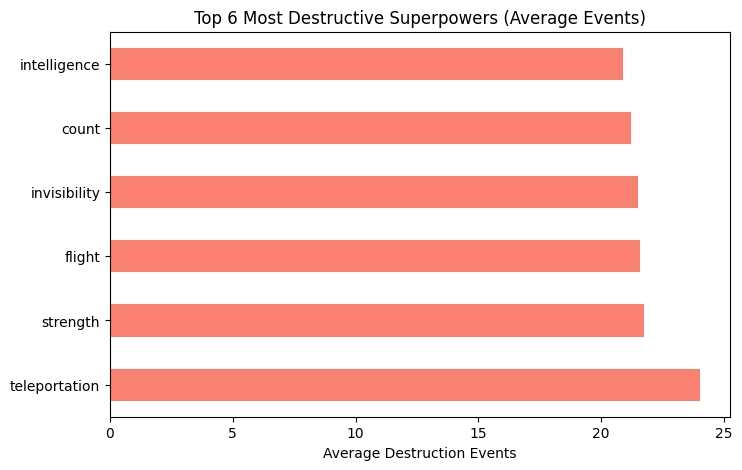

In [12]:
# Get view of top 10 most destructive powers

# Extract power columns (those starting with 'power_')
power_cols = [col for col in train_df.columns if col.startswith('power_')]

# Calculate mean destruction events for heroes with each power
power_impact = {}
for col in power_cols:
    mean_events = train_df[train_df[col] == 1]['annual_public_destruction_events'].mean()
    power_impact[col.replace('power_', '')] = mean_events

# Plot the top 10 most 'destructive' powers
top_powers = pd.Series(power_impact).sort_values(ascending=False).head(10)
top_powers.plot(kind='barh', color='salmon', figsize=(8, 5))
plt.title("Top 6 Most Destructive Superpowers (Average Events)")
plt.xlabel("Average Destruction Events")
# plt.savefig('top_6_most_destructive_powers.png')
# files.download('top_6_most_destructive_powers.png')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

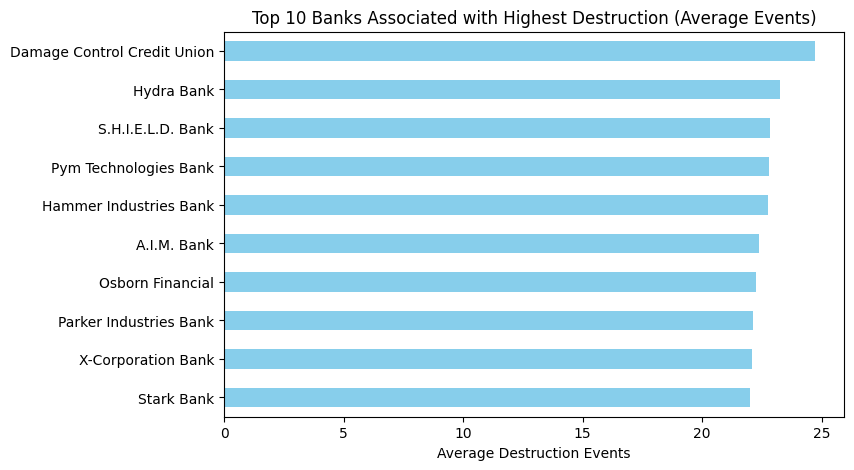

In [11]:
# Get view of top 10 banks most associated with destruction

# 1. Extract bank columns (those starting with 'bank_')
bank_cols = [col for col in train_df.columns if col.startswith('bank_')]

# 2. Calculate mean destruction events for heroes associated with each bank
bank_impact = {}
for col in bank_cols:
    # Filter for rows where the hero has an account at this bank (value is 1)
    # We calculate the mean of the 'annual_public_destruction_events'
    mean_val = train_df[train_df[col] == 1]['annual_public_destruction_events'].mean()

    # Check for NaN in case a bank exists in the test set but not the train set
    if not pd.isna(mean_val):
        bank_impact[col.replace('bank_', '')] = mean_val

# 3. Sort the results and take the top 10
top_banks = pd.Series(bank_impact).sort_values(ascending=False).head(10)

# 4. Plot the results
top_banks.plot(kind='barh', color='skyblue', figsize=(8, 5))
plt.title("Top 10 Banks Associated with Highest Destruction (Average Events)")
plt.xlabel("Average Destruction Events")
plt.gca().invert_yaxis()  # Ensure the highest value is at the top
# plt.savefig('top_10_most_destructive_banks.png')
# files.download('top_10_most_destructive_banks.png')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

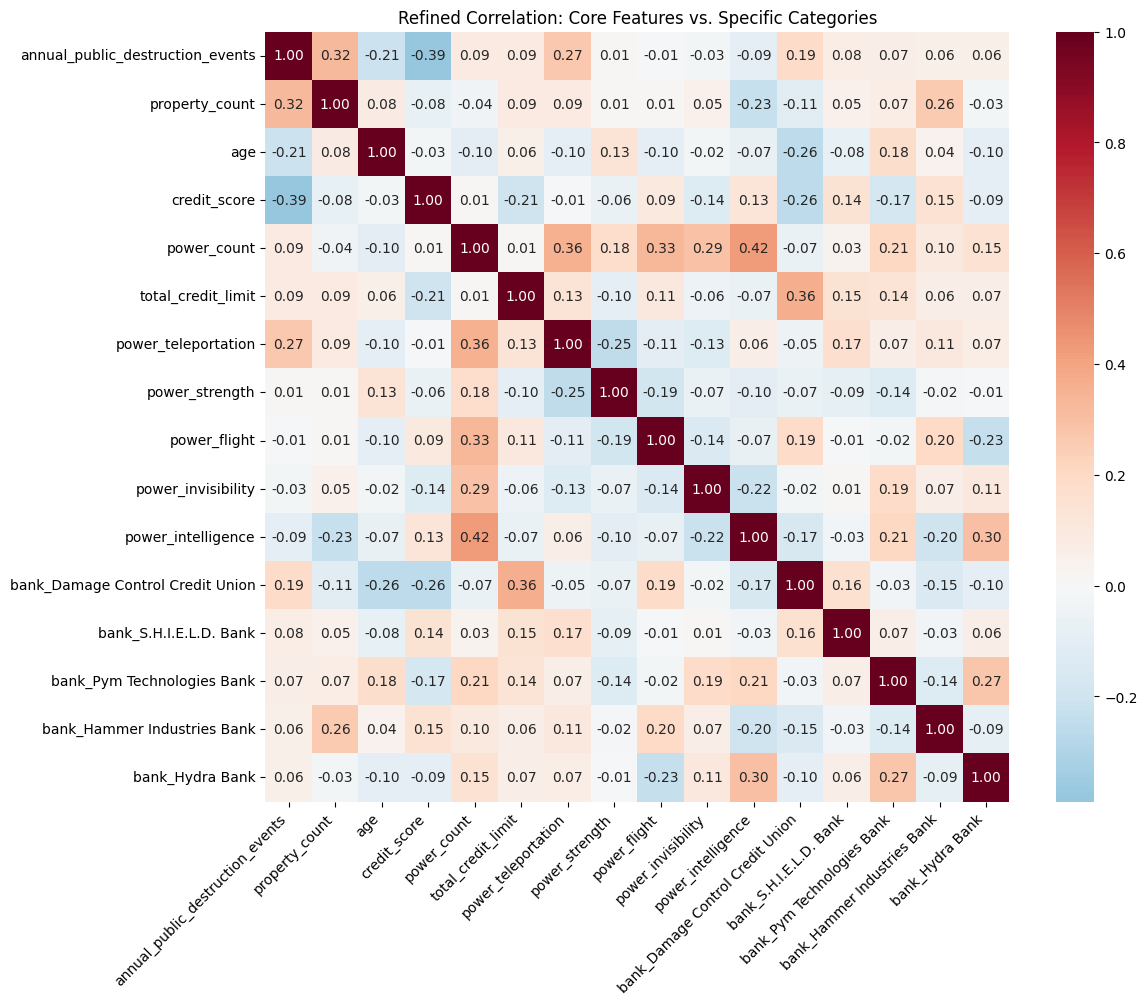

In [13]:
# Create correlation map of all numerical predictors and top 5 qualitative predictors, as obtained from above results

# 1. Calculate correlations against the target
all_corrs = train_df.corr()['annual_public_destruction_events'].sort_values(ascending=False)

# 2. Identify the top 5 SPECIFIC powers (excluding the general 'power_count')
top_power_features = [
    col for col in all_corrs.index
    if col.startswith('power_') and col != 'power_count'
][:5]

# 3. Identify the top 5 banks
top_bank_features = [col for col in all_corrs.index if col.startswith('bank_')][:5]

# 4. Define core numeric predictors (keeping power_count here instead)
core_numeric = ['property_count', 'age', 'credit_score', 'power_count', 'total_credit_limit']

# 5. Combine and Plot
final_feature_subset = ['annual_public_destruction_events'] + core_numeric + top_power_features + top_bank_features
final_corr_matrix = train_df[final_feature_subset].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(final_corr_matrix, annot=True, cmap='RdBu_r', center=0, fmt=".2f")
plt.title("Refined Correlation: Core Features vs. Specific Categories")
plt.xticks(rotation=45, ha='right')
plt.savefig('complete_correlation_map.png')
files.download('complete_correlation_map.png')
plt.show()

# Model Training, Testing and Predictions.

From the above heatmap it is clear that only the predictors property_count, age, credit_score and power_teleporation has meaningfully strong correlation values. I will therefore only use these during model building as to try and avoid overfitting on this small dataset.

In [14]:
# Multiple model testing and 5 fold cross validation to obtain best model for hyper-parameter tuning

# 1. Define the specific features based on your EDA findings
features = ['property_count', 'age', 'credit_score', 'power_teleportation']
X = train_df[features]
y = train_df['annual_public_destruction_events']

# 2. Define a helper to create pipelines (Scaling + Model)
def get_pipeline(model, scale=True):
    if scale:
        return Pipeline([('scaler', StandardScaler()), ('model', model)])
    return Pipeline([('model', model)])

# 3. Initialize the basic versions of each model
model_dict = {
    "Linear Regression": get_pipeline(LinearRegression()),
    "Ridge Regression": get_pipeline(Ridge()),
    "Lasso Regression": get_pipeline(Lasso()),
    "SVR (RBF Kernel)": get_pipeline(SVR()),
    "Bayesian Linear": get_pipeline(BayesianRidge()),
    "XGBoost": get_pipeline(XGBRegressor(n_estimators=100, random_state=42), scale=False),
    "Random Forest": get_pipeline(RandomForestRegressor(n_estimators=100, random_state=42), scale=False)
}

# 4. Evaluate using 5-Fold Cross-Validation (RMSE)
model_results = []

for name, pipe in model_dict.items():
    # Use negative MSE because cross_val_score maximizes the score
    scores = cross_val_score(pipe, X, y, cv=5, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-scores).mean()
    model_results.append({"Model": name, "Mean RMSE": rmse})

# 5. Display the leaderboard
results_df = pd.DataFrame(model_results).sort_values(by="Mean RMSE")
print("Baseline Performance Comparison:")
display(results_df)

Baseline Performance Comparison:


,Model,Mean RMSE
6,Random Forest,5.625056
1,Ridge Regression,5.829180
0,Linear Regression,5.835497
4,Bayesian Linear,5.859369
3,SVR (RBF Kernel),5.926272
5,XGBoost,6.146896
2,Lasso Regression,6.213077


In [16]:
# save initial model training results
results_df.to_excel("initial_model_training_results.xlsx", index=False) # 'index=False' prevents writing the DataFrame index as a column

# 2. Trigger the download to your local machine
files.download("initial_model_training_results.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The Random Forest model performed the best with an RMSE of 5.625056. I will thus proceed with hyper-parameter tuning of this model.

In [17]:
# Define the features and target (using the best ones identified)
features = ['property_count', 'age', 'credit_score', 'power_teleportation']
X = train_df[features]
y = train_df['annual_public_destruction_events']

# 2. Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# 3. Initialize the Grid Search
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# 4. Fit the model
grid_search.fit(X, y)

# 5. Best Parameters and Score
print(f"Best Parameters: {grid_search.best_params_}")
best_rmse = np.sqrt(-grid_search.best_score_)
print(f"Tuned Random Forest RMSE: {best_rmse:.4f}")

# Save the best model for production
best_rf_model = grid_search.best_estimator_

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Tuned Random Forest RMSE: 5.2311


In this context negative values and decimals do not make sense for the predicted number of annual_public_destruction_events. Therefore my prediction will be rounded to the nearest integer and always >= 0.

In [18]:
# Initail unformatted predictions

# Select the same features for the test set
X_test = test_df[features]

# Generate predictions
raw_predictions = best_rf_model.predict(X_test)

# Display the first few predictions
display(raw_predictions)

array([16.95364102, 20.35774653, 26.56188593, 19.29203671, 21.44506788,
       18.18561439, 20.26821529, 22.1746794 , 18.55381249, 18.31496536,
       15.99809732, 22.02039915, 16.31927972, 22.2627349 , 23.51801694,
       22.4402863 , 26.4474575 , 19.16809163, 25.73296993, 17.55700452,
       24.79097445])

In [25]:
# Force all predictions to be 0 or higher

final_predictions = np.maximum(0, raw_predictions)

# Add dataframe
test_df['predicted_annual_public_destruction_events'] = final_predictions

# Verify: Count if any are negative (should be 0)
print(f"Negative predictions found: {(test_df['predicted_annual_public_destruction_events'] < 0).sum()}")

Negative predictions found: 0


In [ ]:
# Round to nearest whole number and convert to integer
test_df['predicted_annual_public_destruction_events'] = test_df['predicted_annual_public_destruction_events'].round().astype(int)

In [27]:
# Final look at predictions
display(test_df["predicted_annual_public_destruction_events"])

,predicted_annual_public_destruction_events
70,17
71,20
72,27
73,19
74,21
75,18
76,20
77,22
78,19
79,18


In [33]:
# save prediction to excel file
test_df["predicted_annual_public_destruction_events"].to_excel("predicted_results.xlsx")
files.download("predicted_results.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [35]:
# 1. Create the final output dataframe using the index of the prospects
final_output = pd.DataFrame(index=test_df.index)

# 2. Retrieve the 'Name' from the original 'df' using the shared index
# We use .loc to ensure we match the correct row index
final_output['Superhero_Name'] = df.loc[test_df.index, 'name']

# 3. Add the Predicted Results from your model
final_output['predicted_annual_public_destruction_events'] = test_df['predicted_annual_public_destruction_events']

# 4. Clean up the formatting
# We move the index to a column so the Excel file is easy to sort
final_output.reset_index(inplace=True)
final_output.rename(columns={'index': 'Original_Database_Index'}, inplace=True)

# 5. Export to Excel
final_output.to_excel('superhero_predictions_final.xlsx', index=False)

print("Success! Final report generated with Names and Predictions.")
display(final_output.head())

Success! Final report generated with Names and Predictions.


,Original_Database_Index,Superhero_Name,predicted_annual_public_destruction_events
0,70,Elektra,17
1,71,Juggernaut,20
2,72,Ant-Man,27
3,73,Thanos,19
4,74,Bucky Barnes,21


# Best model export

In [36]:
import joblib

# Save the model and the feature list to ensure consistency in production
model_data = {
    "model": best_rf_model,
    "features": ['property_count', 'age', 'credit_score', 'power_teleportation']
}
joblib.dump(model_data, 'superhero_model.joblib')

['superhero_model.joblib']